# Machine Learning with Graph Features
## Notebook 2

In this notebook, we will train to ML models to peform selling price predictions. The first will use traditional, one-hot encoded features, while the second will incorporated graph-derived features.

## Connect to TigerGraph Database

The code block below connects to a TigerGraph database. Make sure to change the authentication details in order for you to connect to the instance successfully.

In [1]:
import pyTigerGraph as tg
import numpy as np
import pandas as pd

conn = tg.TigerGraphConnection("http://3.22.188.182", graphname="KDD_2022_NFT", username="tigergraph", password="tigergraph")

conn.gds.configureKafka(kafka_address="kaf.kdd.tigergraphlabs.com:19092")

## Split the Data

In [2]:
splitter = conn.gds.vertexSplitter(v_types=["Transaction"], train=0.8, test=0.2)

In [3]:
splitter.run()

Splitting vertices...
Vertex split finished successfully.


## Traditional Feature Approach

In [4]:
train_loader = conn.gds.vertexLoader(
    attributes={"Transaction": ["usd_price", "categoryOneHot", "collectionOneHot"]},
    filter_by="train",
    batch_size=2048,
    shuffle=True
)

In [5]:
import torch

nn = torch.nn.Sequential(
    torch.nn.Linear(1075, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1)
)

from torch.optim import Adam

opt = Adam(nn.parameters(), lr=0.01)
loss = torch.nn.SmoothL1Loss()
mae = torch.nn.L1Loss()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import numpy as np
def clean_onehots(x, length):
    arr = np.fromstring(x, sep=" ", dtype=np.float32)
    if len(arr) > length:
        arr = arr[:length]
    elif len(arr) < length:
        arr = np.zeros(length)
    return arr

In [7]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/no_graph_feats_training'+str(datetime.now()))

/opt/conda/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


In [8]:
for i in range(20):
    epoch_loss = 0
    epoch_mae = 0
    j = 0
    for batch in train_loader:
        catOH = torch.tensor(np.stack(batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
        collOH = torch.tensor(np.stack(batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
        X = torch.tensor(np.concatenate([catOH, collOH], axis=1))
        y = torch.tensor(batch["Transaction"]["usd_price"].values.astype(np.float32))
        out = nn(X).flatten()
        loss_val = loss(out, y)
        opt.zero_grad()
        loss_val.backward()
        opt.step()
        mae_val = mae(out, y).item()
        epoch_loss += loss_val.item()
        epoch_mae += mae_val

        
        writer.add_scalar('training loss',
                        loss_val.item(),
                        i * train_loader.num_batches + j)
        writer.add_scalar('training mae',
                          mae_val,
                          i * train_loader.num_batches + j)

        j += 1
    print("Epoch:", i, "Loss:", epoch_loss/train_loader.num_batches, "MAE:", epoch_mae/train_loader.num_batches)

Epoch: 0 Loss: 122.24271980921428 MAE: 122.66599893569946
Epoch: 1 Loss: 115.63626432418823 MAE: 116.04793930053711
Epoch: 2 Loss: 113.33624347050984 MAE: 113.75316937764485
Epoch: 3 Loss: 112.67221593856812 MAE: 113.08462746938069
Epoch: 4 Loss: 111.37817335128784 MAE: 111.7907207806905
Epoch: 5 Loss: 111.08420880635579 MAE: 111.505934715271
Epoch: 6 Loss: 109.67613855997722 MAE: 110.0979946454366
Epoch: 7 Loss: 110.22235043843587 MAE: 110.63220119476318
Epoch: 8 Loss: 109.92433563868205 MAE: 110.34885342915852
Epoch: 9 Loss: 108.80897696812947 MAE: 109.22657744089763
Epoch: 10 Loss: 110.09890715281169 MAE: 110.51529916127522
Epoch: 11 Loss: 109.77395009994507 MAE: 110.19121424357097
Epoch: 12 Loss: 109.23179149627686 MAE: 109.6538044611613
Epoch: 13 Loss: 108.53418509165446 MAE: 108.94728708267212
Epoch: 14 Loss: 107.99553553263347 MAE: 108.4133513768514
Epoch: 15 Loss: 108.51784149805705 MAE: 108.9344671567281
Epoch: 16 Loss: 108.13285048802693 MAE: 108.54760615030925
Epoch: 17 Loss

In [9]:
test_loader = conn.gds.vertexLoader(
    attributes={"Transaction": ["usd_price", "categoryOneHot", "collectionOneHot"]},
    filter_by="test",
    batch_size=2048
)

In [10]:
mae_sum = 0
for batch in test_loader:
    catOH = torch.tensor(np.stack(batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
    collOH = torch.tensor(np.stack(batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
    X = torch.tensor(np.concatenate([catOH, collOH], axis=1))
    y = torch.tensor(batch["Transaction"]["usd_price"].values.astype(np.float32))
    with torch.no_grad():
        out = nn(X).flatten()
        mae_sum += mae(out, y).item()
print("MAE:", mae_sum/test_loader.num_batches,)

MAE: 100.38905652364095


## Add Graph Features

In [11]:
%%writefile ./seller_pagerank.gsql

CREATE QUERY seller_pagerank(BOOL print_accum = FALSE, STRING result_attr = "") {
    transactions = {Transaction.*};
    SumAccum<DOUBLE> @seller_pr;
    MaxAccum<DOUBLE> @@max_seller_pr;


    res = SELECT t FROM transactions:t -(NFT_SOLD_BY)-> NFT_User:u 
          ACCUM
            t.@seller_pr += u.pagerank,
            @@max_seller_pr += u.pagerank
          POST-ACCUM
            IF result_attr != "" THEN
                t.setAttr(result_attr, t.@seller_pr/@@max_seller_pr)
            END;
    IF print_accum THEN
      PRINT res[res.@seller_pr];
    END;
}

Overwriting ./seller_pagerank.gsql


In [12]:
featurizer = conn.gds.featurizer()

In [13]:
featurizer.installAlgorithm("seller_pagerank", query_path="./seller_pagerank.gsql")

'seller_pagerank'

In [14]:
params = {"result_attr": "seller_pr"}

try:
    featurizer.runAlgorithm("seller_pagerank", params, feat_name="seller_pr", feat_type="DOUBLE", custom_query=True, schema_name=["Transaction"])
except ConnectionError:
    featurizer.runAlgorithm("seller_pagerank", params)

In [15]:
%%writefile ./buyer_pagerank.gsql

CREATE QUERY buyer_pagerank(BOOL print_accum = FALSE, STRING result_attr = "") {
    transactions = {Transaction.*};
    SumAccum<DOUBLE> @buyer_pr;
    MaxAccum<DOUBLE> @@max_buyer_pr;


    res = SELECT t FROM transactions:t -(NFT_BOUGHT_BY)-> NFT_User:u 
          ACCUM
            t.@buyer_pr += u.pagerank,
            @@max_buyer_pr += u.pagerank
          POST-ACCUM
            IF result_attr != "" THEN
                t.setAttr(result_attr, t.@buyer_pr/@@max_buyer_pr)
            END;
    IF print_accum THEN
      PRINT res[res.@buyer_pr];
    END;
}

Overwriting ./buyer_pagerank.gsql


In [16]:
featurizer.installAlgorithm("buyer_pagerank", query_path="./buyer_pagerank.gsql")

'buyer_pagerank'

In [17]:
params = {"result_attr": "buyer_pr"}

try:
    featurizer.runAlgorithm("buyer_pagerank", params, feat_name="buyer_pr", feat_type="DOUBLE", custom_query=True, schema_name=["Transaction"])
except ConnectionError:
    featurizer.runAlgorithm("buyer_pagerank", params)

In [18]:
%%writefile ./kcore_size.gsql

CREATE QUERY kcore_size(BOOL print_accum = FALSE, STRING result_attr = "") FOR GRAPH KDD_2022_NFT { 
  MapAccum<INT, SumAccum<FLOAT>> @@kcore_size;
  MaxAccum<FLOAT> @@max_kcore_size;

  
  nftuser = {NFT_User.*};
  
  res = SELECT t FROM nftuser:t POST-ACCUM @@kcore_size += (t.k_core -> 1);
  
  IF print_accum THEN
    PRINT @@kcore_size;
  END;

  FOREACH (key, value) IN @@kcore_size DO
    @@max_kcore_size += value;
  END;
  
  IF result_attr != "" THEN
    res = SELECT t FROM nftuser:t POST-ACCUM t.setAttr(result_attr, @@kcore_size.get(t.k_core)/@@max_kcore_size);
  END;
}

Overwriting ./kcore_size.gsql


In [19]:
featurizer.installAlgorithm("kcore_size", query_path="./kcore_size.gsql")

'kcore_size'

In [20]:
params = {"result_attr": "kcore_size"}
try:
    featurizer.runAlgorithm("kcore_size", params, feat_name="kcore_size", feat_type="DOUBLE", custom_query=True, schema_name=["NFT_User"])
except ConnectionError:
    featurizer.runAlgorithm("kcore_size", params, custom_query=True)

In [21]:
%%writefile ./seller_kcore_size.gsql

CREATE QUERY seller_kcore_size(BOOL print_accum = FALSE, STRING result_attr = "") {
    transactions = {Transaction.*};
    SumAccum<DOUBLE> @seller_k_size;


    res = SELECT t FROM transactions:t -(NFT_SOLD_BY)-> NFT_User:u 
          ACCUM
            t.@seller_k_size += u.kcore_size
          POST-ACCUM
            IF result_attr != "" THEN
                t.setAttr(result_attr, t.@seller_k_size)
            END;
    IF print_accum THEN
      PRINT res[res.@seller_k_size];
    END;
}

Overwriting ./seller_kcore_size.gsql


In [22]:
featurizer.installAlgorithm("seller_kcore_size", query_path="./seller_kcore_size.gsql")

'seller_kcore_size'

In [23]:
params = {"result_attr": "seller_k_size"}

try:
    featurizer.runAlgorithm("seller_kcore_size", params, feat_name="seller_k_size", feat_type="DOUBLE", custom_query=True, schema_name=["Transaction"])
except ConnectionError:
    featurizer.runAlgorithm("seller_kcore_size", params)

In [24]:
%%writefile ./buyer_kcore_size.gsql

CREATE QUERY buyer_kcore_size(BOOL print_accum = FALSE, STRING result_attr = "") {
    transactions = {Transaction.*};
    SumAccum<DOUBLE> @buyer_k_size;


    res = SELECT t FROM transactions:t -(NFT_BOUGHT_BY)-> NFT_User:u 
          ACCUM
            t.@buyer_k_size += u.kcore_size
          POST-ACCUM
            IF result_attr != "" THEN
                t.setAttr(result_attr, t.@buyer_k_size)
            END;
    IF print_accum THEN
      PRINT res[res.@buyer_k_size];
    END;
}

Overwriting ./buyer_kcore_size.gsql


In [25]:
featurizer.installAlgorithm("buyer_kcore_size", query_path="./buyer_kcore_size.gsql")

'buyer_kcore_size'

In [26]:
params = {"result_attr": "buyer_k_size"}

try:
    featurizer.runAlgorithm("buyer_kcore_size", params, feat_name="buyer_k_size", feat_type="DOUBLE", custom_query=True, schema_name=["Transaction"])
except ConnectionError:
    featurizer.runAlgorithm("buyer_kcore_size", params)

In [27]:
tmp = conn.getSchema(force=True)

## Train Neural Network with Graph-Based Features

In [28]:
train_loader = conn.gds.vertexLoader(
    attributes={"Transaction": ["buyer_k_size", "seller_k_size", "usd_price", "seller_pr", "buyer_pr", "categoryOneHot", "collectionOneHot"]},
    filter_by="train",
    batch_size=2048,
    shuffle=True
)

In [29]:
import torch

nn = torch.nn.Sequential(
    torch.nn.Linear(1079, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1)
)

from torch.optim import Adam

opt = Adam(nn.parameters(), lr=0.01)
loss = torch.nn.SmoothL1Loss()
mae = torch.nn.L1Loss()

In [30]:
writer = SummaryWriter('runs/graph_feats_training'+str(datetime.now()))

In [31]:
for i in range(20):
    epoch_loss = 0
    epoch_mae = 0
    j = 0
    for batch in train_loader:
        catOH = torch.tensor(np.stack(batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
        collOH = torch.tensor(np.stack(batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
        X = torch.tensor(np.concatenate([batch["Transaction"][["seller_k_size", "buyer_k_size", "seller_pr", "buyer_pr"]].values.astype(np.float32), catOH, collOH], axis=1))
        y = torch.tensor(batch["Transaction"]["usd_price"].values.astype(np.float32))
        out = nn(X).flatten()
        loss_val = loss(out, y)
        opt.zero_grad()
        loss_val.backward()
        opt.step()
        mae_val = mae(out, y).item()
        epoch_loss += loss_val.item()
        epoch_mae += mae_val
        writer.add_scalar('training loss',
                        loss_val.item(),
                        i * train_loader.num_batches + j)
        writer.add_scalar('training mae',
                          mae_val,
                          i * train_loader.num_batches + j)
        j += 1
    print("Epoch:", i, "Loss:", epoch_loss/train_loader.num_batches, "MAE:", epoch_mae/train_loader.num_batches)

Epoch: 0 Loss: 121.71501143773396 MAE: 122.13668966293335
Epoch: 1 Loss: 115.91950861612956 MAE: 116.33676687876384
Epoch: 2 Loss: 113.2590519587199 MAE: 113.67045640945435
Epoch: 3 Loss: 111.77474164962769 MAE: 112.18677568435669
Epoch: 4 Loss: 111.03146807352702 MAE: 111.44589042663574
Epoch: 5 Loss: 110.19159809748332 MAE: 110.6090784072876
Epoch: 6 Loss: 108.67591285705566 MAE: 109.09672387440999
Epoch: 7 Loss: 108.28981892267863 MAE: 108.69835011164348
Epoch: 8 Loss: 108.13271427154541 MAE: 108.55373350779216
Epoch: 9 Loss: 108.14895391464233 MAE: 108.56286827723186
Epoch: 10 Loss: 109.17181094487508 MAE: 109.59185282389323
Epoch: 11 Loss: 107.0132687886556 MAE: 107.42823060353597
Epoch: 12 Loss: 106.520276705424 MAE: 106.93150059382121
Epoch: 13 Loss: 107.23868544896443 MAE: 107.6545278231303
Epoch: 14 Loss: 106.91179418563843 MAE: 107.3196398417155
Epoch: 15 Loss: 106.72891823450725 MAE: 107.14272499084473
Epoch: 16 Loss: 106.72746594746907 MAE: 107.1395936012268
Epoch: 17 Loss:

In [32]:
test_loader = conn.gds.vertexLoader(
    attributes={"Transaction": ["seller_k_size", "buyer_k_size", "usd_price", "seller_pr", "buyer_pr", "categoryOneHot", "collectionOneHot"]},
    filter_by="test",
    batch_size=2048
)

In [33]:
mae_sum = 0
for batch in test_loader:
    catOH = torch.tensor(np.stack(batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
    collOH = torch.tensor(np.stack(batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
    X = torch.tensor(np.concatenate([batch["Transaction"][["seller_k_size", "buyer_k_size", "seller_pr", "buyer_pr"]].values.astype(np.float32), catOH, collOH], axis=1))
    y = torch.tensor(batch["Transaction"]["usd_price"].values.astype(np.float32))
    with torch.no_grad():
        out = nn(X).flatten()
        mae_sum += mae(out, y).item()
print("MAE:", mae_sum/test_loader.num_batches)

MAE: 102.30754852294922


## Determine Graph Feature Importance

In [34]:
!pip install captum

In [35]:
from captum.attr import GradientShap

gs = GradientShap(nn)

/opt/conda/lib/python3.8/site-packages/captum/attr/_utils/visualization.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [36]:
train_X = []


for train_batch in train_loader:
    catOH = torch.tensor(np.stack(train_batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
    collOH = torch.tensor(np.stack(train_batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
    train_x = torch.tensor(np.concatenate([train_batch["Transaction"][["seller_k_size", "buyer_k_size", "seller_pr", "buyer_pr"]].values.astype(np.float32), catOH, collOH], axis=1))
    train_X.append(train_x)
train_X = torch.concat(train_X)

test_X = []
for test_batch in test_loader:
    catOH = torch.tensor(np.stack(test_batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
    collOH = torch.tensor(np.stack(test_batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
    test_x = torch.tensor(np.concatenate([test_batch["Transaction"][["seller_k_size", "buyer_k_size", "seller_pr", "buyer_pr"]].values.astype(np.float32), catOH, collOH], axis=1))
    test_X.append(test_x)
test_X = torch.concat(test_X)

In [37]:
train_X.shape

torch.Size([47451, 1079])

In [38]:
test_X.shape

torch.Size([11883, 1079])

In [39]:
attribution = gs.attribute(test_X, train_X)

[Text(0, 0, 'Seller_k_size'),
 Text(1, 0, 'Buyer_k_size'),
 Text(2, 0, 'Seller_pr'),
 Text(3, 0, 'Buyer_pr')]

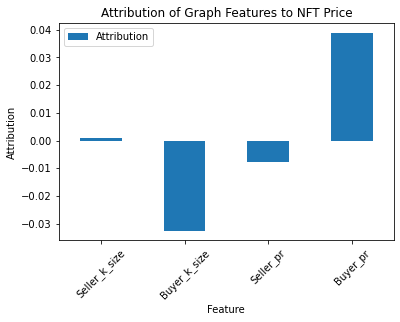

In [40]:
ig_nt_attr_test_sum = attribution.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

attributions = pd.DataFrame({"Feature": ["Seller_k_size", "Buyer_k_size", "Seller_pr", "Buyer_pr"], "Attribution": ig_nt_attr_test_norm_sum[:4]})

plt = attributions.plot(kind="bar", xlabel="Feature", ylabel="Attribution", title="Attribution of Graph Features to NFT Price")
plt.set_xticklabels(attributions.Feature, rotation=45)